This notebook performs the construction of the GME-based, non-Markovian Model for the villin headpiece system. The model is built upon featurized trajectories after feature selection. SRVs are used for dimensionality reduction. To manage time constraints, we eliminate two steps here: cross-validation to determine the hyperparameters to construct microstate-MSM and boostrapping to validate microstate-MSM.

In [ ]:
# @title Install packages and download the necessary files (takes about 1 min)
!pip install msmbuilder2022
!pip install numpy==1.23.5
!pip install matplotlib
!pip install scipy
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install tqdm
!curl -L https://uwmadison.box.com/shared/static/1y12gymo0tkc5dn3nihhqwzikxa8wzen --output oasis_trajs.npy
!wget https://github.com/xuhuihuang/GME_tutorials/raw/main/tutorials/villin_headpiece/scripts/VAMPNet_SRVNet.py
!wget https://github.com/xuhuihuang/GME_tutorials/raw/main/quasi-MSM/qmsm.py
!wget https://github.com/xuhuihuang/GME_tutorials/raw/main/IGME/igme.py

In [ ]:
# @title Import necessary packages
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from msmbuilder.decomposition import tICA
from msmbuilder.cluster import KMeans, KCenters, MiniBatchKMeans
from msmbuilder.msm import MarkovStateModel
from msmbuilder.lumping import PCCAPlus
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import *

from VAMPNet_SRVNet import *
from igme import IGMENS, IGME
from qmsm import QuasiMSM, MSM

In [ ]:
# @title SRVs: Dimensionality reduction (takes 4-5 min)
oasis_trajs = np.load('oasis_trajs.npy', allow_pickle=True)

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

## Set the random seed to ensure the reproducible training (not necessary)
set_random_seed(20)

network_lobe = nn.Sequential(
    nn.BatchNorm1d(400),
    nn.Linear(400, 200), nn.ELU(),
    nn.Linear(200, 100), nn.ELU(),
    nn.Linear(100, 50), nn.ELU(),
    nn.Linear(50, 20), nn.ELU(),
    nn.Linear(20, 10), nn.ELU(),
    nn.Linear(10, 5), nn.ELU(),
    nn.Linear(5, 3))

network_lobe = network_lobe.to(device=device)

projector = deep_projector(network_type='SRVNet', lobe=network_lobe,
                           epsilon=1e-6, learning_rate=1e-4, device=device)

past, future = TimeLaggedDataset(trajs=oasis_trajs, lagtime=200, normalize=False)
train_loader, validation_loader =  split_train_validate_data(pastdata=past, futuredata=future, validation_ratio=0.2, train_batchsize=50000)
projector.fit(train_loader=train_loader, num_epochs=15, validation_loader=validation_loader)

srv_trajs = projector.transform(data=oasis_trajs)
srv_trajs = np.array(srv_trajs, dtype=object)

# This tICA is for normalization, not for dimensionality reduction
tica = tICA(n_components=3, lag_time=200, kinetic_mapping=False)
ntrajs = tica.fit_transform(srv_trajs)
ntrajs = np.array(ntrajs, dtype=object)

In [ ]:
# @title K-Centers: geometric clustering
cluster = KCenters(n_clusters=200, random_state=42)
clustered_trajs = cluster.fit_transform(ntrajs)
clustered_trajs = np.array(clustered_trajs, dtype=object)

In [ ]:
# @title PCCA+: Kinetic lumping
n_macro=4
msm = MarkovStateModel(n_timescales=10, lag_time=5, reversible_type='transpose',
                       verbose=False, ergodic_cutoff='off')
msm.fit(clustered_trajs)
pcca = PCCAPlus.from_msm(msm, n_macrostates=n_macro)
lumped_trajs = pcca.fit_transform(clustered_trajs)
lumped_trajs = np.array(lumped_trajs, dtype=object)

In [ ]:
# @title Use mle method to get the symmetrized macrostate TPM
def generate_TPM(trajs, lagtime):
    TPM = []
    for i in range(len(lagtime)):
        msm_macro = MarkovStateModel(n_timescales=3, lag_time=lagtime[i],
                                     ergodic_cutoff='on', reversible_type='mle', verbose=False)
        msm_macro.fit(trajs)
        TPM.append(msm_macro.transmat_)
    return np.array(TPM)

n_macro = 4
lagtime = np.arange(5,1501,5)
TPM = generate_TPM(trajs = lumped_trajs, lagtime = lagtime)

In [ ]:
# @title Generate the boostrapping TPM (takes about 12 min)
num_runs = 50
num_samples_per_run = 150
bootstrap_TPM = np.zeros((num_runs, len(lagtime), n_macro, n_macro))
for i in range(num_runs):
    bootstrap_indices = np.random.choice(range(len(lumped_trajs)), size=num_samples_per_run, replace=True)
    bootstrap_trajs = [lumped_trajs[i] for i in bootstrap_indices]
    bootstrap_TPM[i] = generate_TPM(bootstrap_trajs, lagtime=lagtime)
    print('Run {} is complete'.format(i))

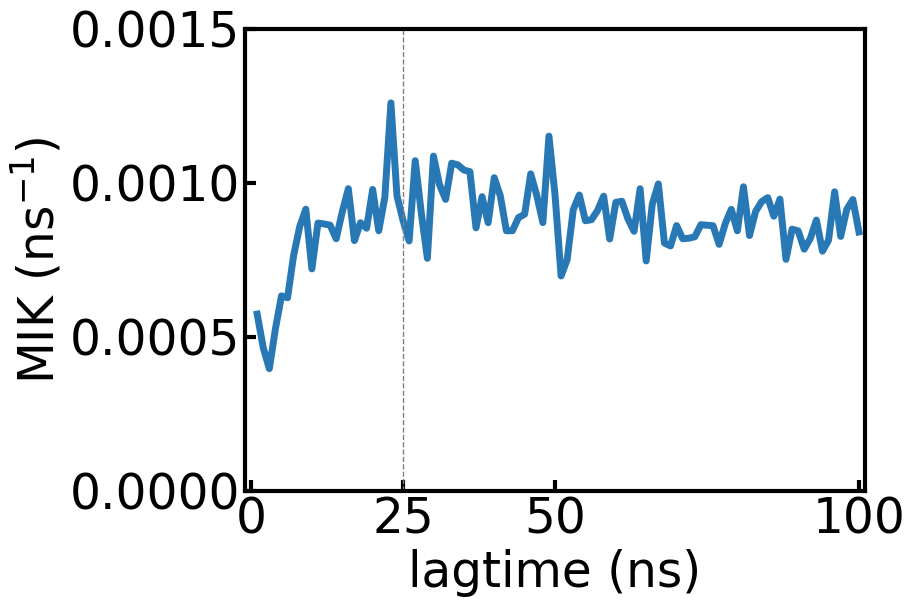

In [ ]:
# @title Compute Mean Integeral Kernel (MIK) from qMSM
delta_t = 1 # unit: ns

# MIK computed from qMSM
qmsm = QuasiMSM()
lagtime = np.arange(1, 101) * delta_t
qmsm.fit(TPM, tau_k=100, delta_t=delta_t, rmse=False)

plt.rcParams['font.size'] = 35
fig, ax = plt.subplots(figsize=(8,6))
# plt.fill_between(np.linspace(-1, 101, 100),mik_mean-mik_std, mik_mean+mik_std, color='#C82423', alpha=0.5, linewidth=0)
# plt.axhline(y=mik_mean, color='#C82423', linestyle='--', linewidth=5)
plt.plot(lagtime, qmsm.mik, color='#2878B5', linewidth=5, label='qMSM')
plt.axvline(x=25, color='grey', linewidth=1, linestyle='--')
plt.ylim(0, 0.0015)
plt.xlim(-1, 101)
plt.xlabel('lagtime (ns)')
plt.ylabel('MIK (ns$^{-1}$)')
ax.tick_params(axis='both', direction='in', width=3, length=8)

ax.set_xticks(ticks=[0,25,50,100])
for spine in ax.spines.values():
    spine.set_linewidth(3)
plt.show()

In [ ]:
# @title Build qMSM

# Compute RMSE of qMSM
qmsm = QuasiMSM()
qmsm.fit(TPM, tau_k=50, delta_t=delta_t)
qmsm_rmse = qmsm.rmse

# Build qMSM
qmsm = QuasiMSM()
qmsm.fit(TPM, tau_k=25, delta_t=delta_t)
qmsm_time, qmsm_tpm = qmsm.predict(TPM) # Use qMSM for prediction
qmsm_its = qmsm.timescales(TPM, ITS_t=500) # ITS predicted by qMSM

In [ ]:
# @title Build IGME

# Scan tau_k and L of IGME
igme = IGME()
scan_output = igme.scan(input_data=TPM, begin=1, end=50)

# Build top IGME for CK-test
igme_top = igme.top_model(scan_output, 1) # Select the top IGME model
igme_tpm = np.array(igme_top.predict(1,len(TPM))) # Use IGME for prediction

# Compute MIK and ITS based on top 5% IGME models
top_outputs = igme.top_outputs(scan_output, n=0.05, max_its=1e5)
igme_mik = np.array(top_outputs['mik'])[:,1] / delta_t
igme_its = np.array(top_outputs['timescales']) * delta_t

In [ ]:
# @title Build macrostate-MSM

# Compute RMSE of MSM
msm = MSM()
tau = np.arange(1, 151)
msm_rmse = msm.scan(TPM, delta_t=1, tau_lst=tau)

# Build 150 ns MSM
msm.fit(TPM, tau=150, delta_t = 1, rmse=True)
msm_time, msm_tpm = msm.predict(end=len(TPM))

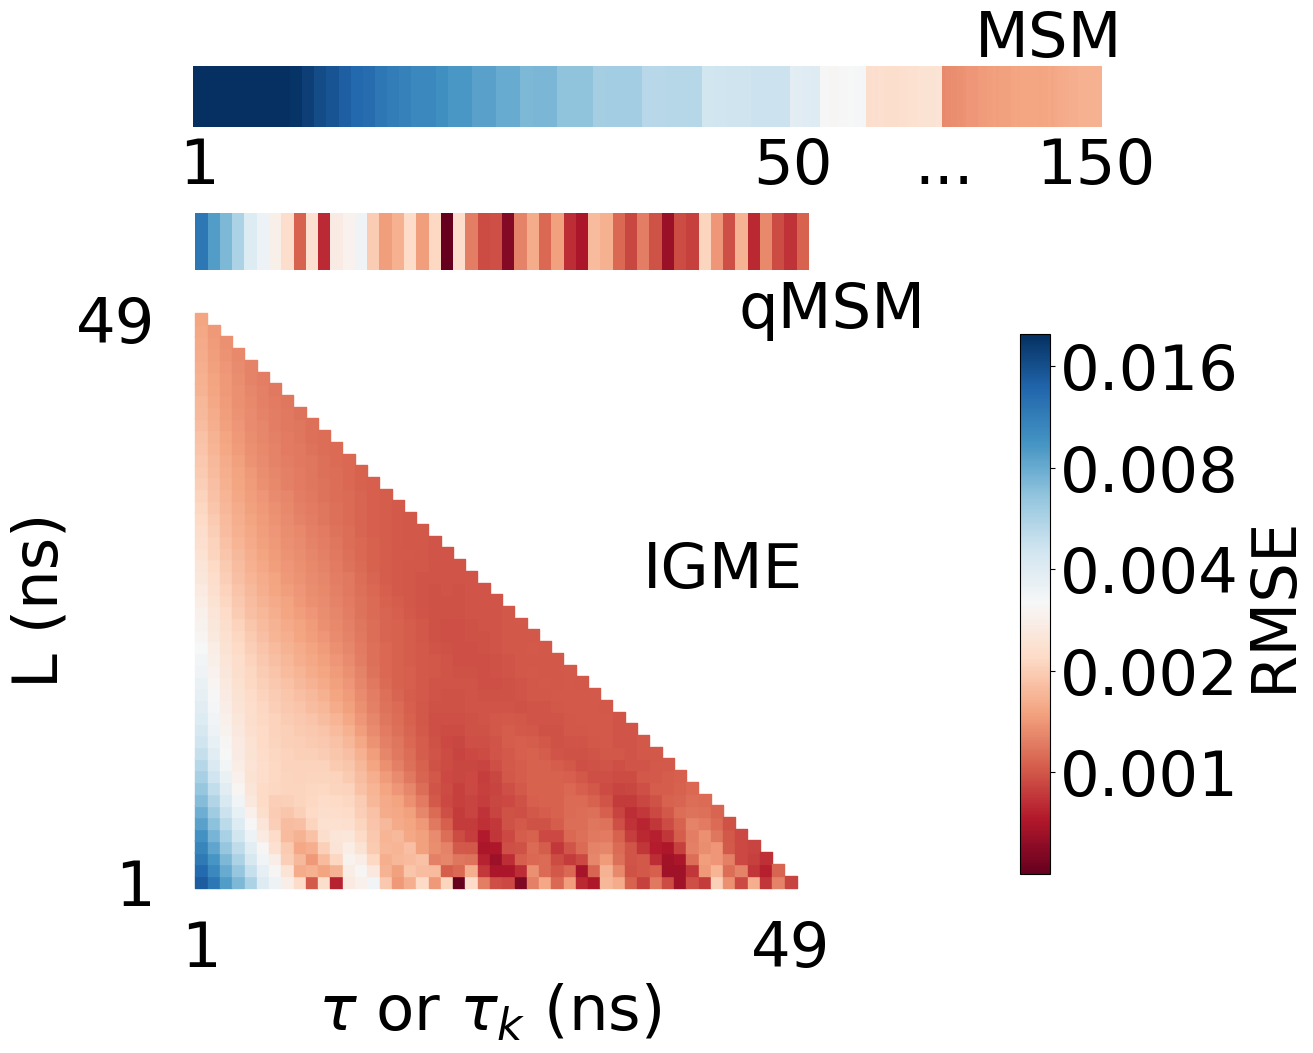

In [ ]:
# @title Plot RMSE map

def adjust_tau(x):
    if x < 50:
        return x
    else:
        return x/4 + 37.5

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors

x = [i for i in scan_output['begin']]
y = [(scan_output['end'][i] - scan_output['begin'][i]) for i in range(len(x))]
z = scan_output['rmse']

plt.rcParams['font.size'] = 45
cmap_name = 'RdBu'  # You can use any colormap of your choice from Matplotlib's colormaps
custom_cmap = plt.get_cmap(cmap_name)
norm = mcolors.LogNorm(vmin=5e-4, vmax=2e-2)

fig, axes = plt.subplots(2, 1, figsize=(10,9), sharex=True,
                         gridspec_kw={'height_ratios': [1, 7]})

qmsm_color_bar = custom_cmap(norm(qmsm_rmse))
qmsm_tauk_time = np.arange(1, 51, 1)
upper_bound = np.ones(len(qmsm_color_bar))*1.6
axes[0].bar(qmsm_tauk_time, upper_bound, color=qmsm_color_bar, width=1)
axes[0].set_yticks([])
axes[0].set_xticks([])
axes[0].set_ylim(-0.5, 2)
axes[0].text(60, -2, 'qMSM', ha='right', va='bottom')
axes[0].set_frame_on(False)
axes[0].tick_params(left=False, right=False, bottom=False, top=False)

axes[1].scatter(x, y, c=z,
                cmap=custom_cmap, norm=norm, marker='s', s=75)
axes[1].text(50, 25, 'IGME', ha='right', va='bottom')
axes[1].set_frame_on(False)
axes[1].tick_params(left=False, right=False, bottom=False, top=False)
axes[1].set_xticks([1, 49])
axes[1].set_yticks([1, 49])
fig.text(0.45, 0.03, '$\\tau$ or $ \\tau_k $ (ns)', ha='center', va='top')
axes[1].set_ylabel('L (ns)')

plt.subplots_adjust(hspace=0.01)
fig.subplots_adjust(top=0.9)
msm_ax = fig.add_axes([0.108, 0.98, 1, 0.13])
tau = np.arange(1, 151)
upper_bound = np.ones(len(tau))*0.52
msm_color_bar = custom_cmap(norm(msm_rmse))
msm_ax.bar([adjust_tau(i) for i in tau], upper_bound, color=msm_color_bar, width=1)
msm_ax.set_yticks([])
msm_ax.set_xticks([])
msm_ax.set_ylim(0, 1)
msm_ax.set_xticks([1,50, 62.5, 75], labels=[1,50,"...",150])
msm_ax.text(65,0.6,'MSM')
msm_ax.set_frame_on(False)
msm_ax.tick_params(left=False, right=False, bottom=False, top=False)


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.98, 0.15, 0.03, 0.6])
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=custom_cmap), cax=cbar_ax)
ticks = [1e-3, 2e-3, 4e-3, 8e-3, 1.6e-2]
cbar.set_ticks(ticks)
cbar.set_ticklabels(ticks)
cbar.ax.minorticks_off()
cbar.set_label('RMSE')
plt.show()

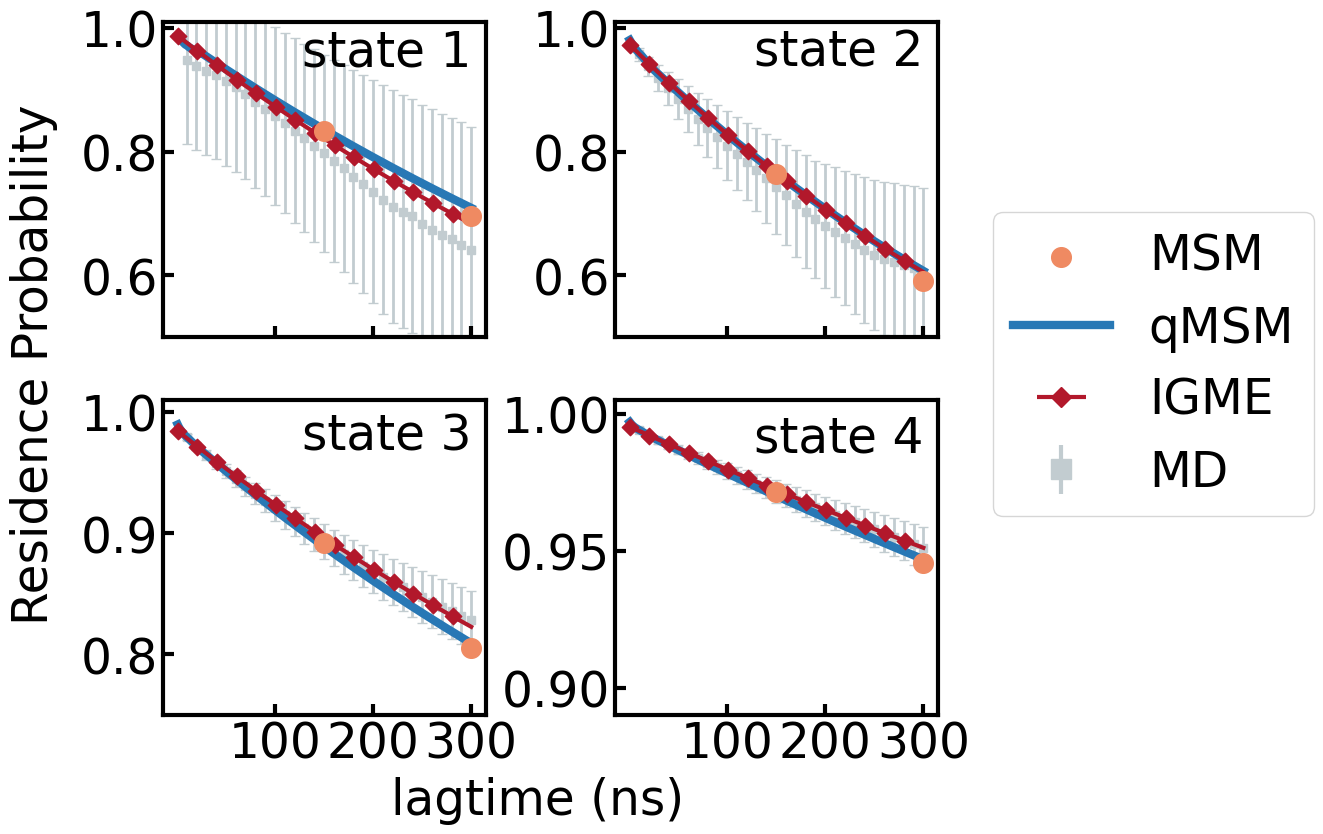

In [ ]:
# @title CK test
plt.rcParams['font.size'] = 35

length = 300
lt = np.arange(1,length+1)
n_state = 4

TPM_mean = np.mean(bootstrap_TPM, axis=0)
TPM_std = np.std(bootstrap_TPM, axis=0)
fig, axes = plt.subplots(2,2,figsize=(10,9), sharex=True)
for i in range(n_state):
    ax = axes[i//2, i-(i//2)*2]
#     ax.fill_between(lt, TPM_mean[:length,i,i]-TPM_std[:length,i,i],
#                     TPM_mean[:length,i,i]+TPM_std[:length,i,i], color='#fff2df')
    ax.errorbar(x=lt[-1::-10], y=TPM_mean[-1::-10,i,i], yerr=TPM_std[-1::-10,i,i],
                fmt='s', capsize=3.5, elinewidth=2, ecolor='#c2ccd0', color='#c2ccd0',
                zorder=0)
    ax.plot(qmsm_time, qmsm_tpm[:,i,i], color='#2878B5', linewidth=6, zorder=2)

    ax.plot(lt, igme_tpm[:length,i,i], color='#b2182b', linewidth=3, zorder=3)
    ax.scatter(lt[::20], igme_tpm[::20,i,i], c='#b2182b', marker='D', s=70, zorder=3)

    ax.scatter(msm_time, msm_tpm[:,i,i], c='#ef8a62', s=200, zorder=4)
    ax.text(300, 1, 'state {}'.format(i+1), ha='right',va='top')


    ax.tick_params(axis='both', direction='in', width=3, length=8)
    ax.set_xticks(ticks=[100,200,300],labels=[100,200,300] )
    for spine in ax.spines.values():
        spine.set_linewidth(3)

axes[0, 0].set_ylim(0.5, 1.01)
axes[0, 1].set_ylim(0.5, 1.01)
axes[1, 0].set_ylim(0.75, 1.01)
axes[1, 1].set_ylim(0.89, 1.005)

plt.scatter([], [], c='#ef8a62', s=200, label='MSM')
plt.plot([], [], label='qMSM', color='#2878B5', linewidth=6)
plt.errorbar([], [], xerr=[], color='#b2182b', label='IGME', fmt='D',
             markersize=10, elinewidth=3, capsize=3)
plt.errorbar([], [], yerr=[], color='#c2ccd0', label='MD', fmt='s',
             markersize=15, elinewidth=3, capsize=3)
fig.text(0.5, 0, 'lagtime (ns)', ha='center')
fig.text(0.02, 0.5, "Residence Probability", ha='right', va='center', rotation=90)
fig.legend(loc='center right', bbox_to_anchor=(1.3, 0.5))
plt.subplots_adjust(wspace=0.4)
plt.show()

In [ ]:
# @title The timescales
print("Implied Timescales of 150 ns MSM:")
print(msm.timescales)

print("\nImplied Timescales of qMSM at 500 ns:")
print(qmsm_its)

print("\nImplied Timescales of IGME:")
print(igme_top.timescales)

print("\nThe mean values of the implied timescales among the top 5% IGME models: ")
print(np.mean(np.array(top_outputs['timescales']), axis=0))

print("\nThe standard deviation of the implied timescales among the top 5% IGME models: ")
print(np.std(np.array(top_outputs['timescales']), axis=0))

Implied Timescales of 150 ns MSM:
[1608.48777841  789.65394091  463.61219226]

Implied Timescales of qMSM at 500 ns:
[1640.56407344  842.36573755  508.70698226]

Implied Timescales of IGME:
[1925.11814573  777.35728432  523.24692283]

The mean values of the implied timescales among the top 5% IGME models: 
[1869.26382992 1153.81638582  497.15119225]

The standard deviation of the implied timescales among the top 5% IGME models: 
[415.65768812 173.82127375  31.89393028]


In [ ]:
# @title RMSE
print("RMSE of 150 ns MSM:")
print(msm.rmse)

print("\nRMSE of qMSM:")
print(qmsm.rmse[-1])

print("\nRMSE of IGME:")
print(igme_top.rmse)

print("\nThe RMSE among the top 5% IGME models fall below: ")
print(np.max(top_outputs['rmse']))

RMSE of 150 ns MSM:
0.0016487676178400118

RMSE of qMSM:
0.0009733054361714295

RMSE of IGME:
0.0004284748039510611

The RMSE among the top 5% IGME models fall below: 
0.0009047395053397133


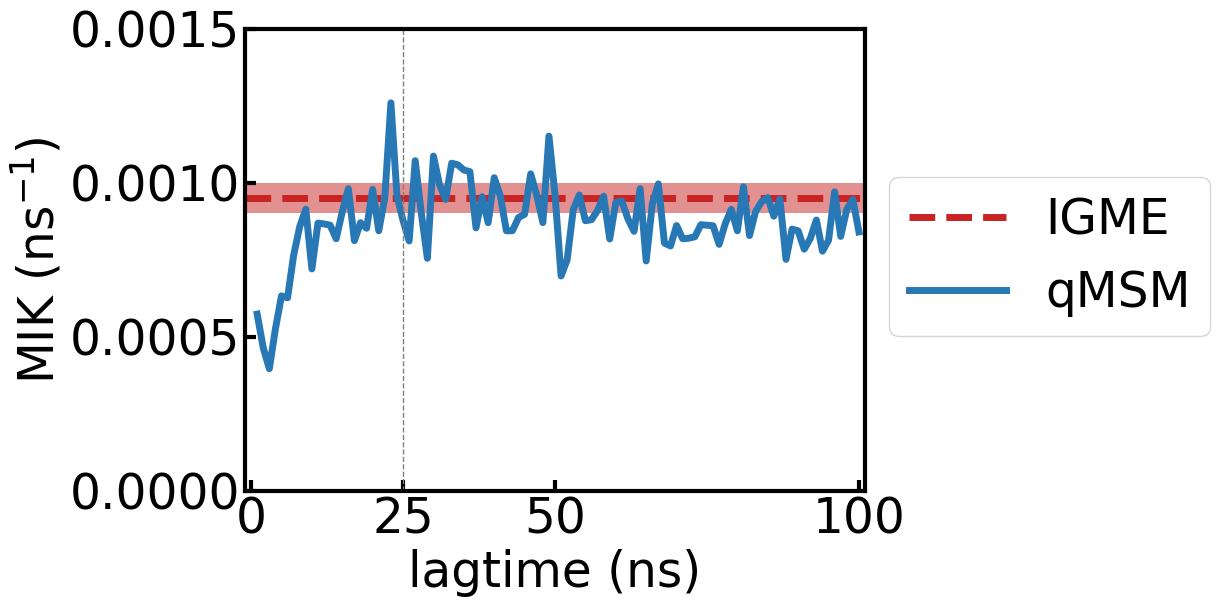

In [ ]:
# @title MIK computed from qMSM and IGME
qmsm = QuasiMSM()
lagtime = np.arange(1, 101) * delta_t
qmsm.fit(TPM, tau_k=100, delta_t=delta_t, rmse=False)
mik_mean = np.mean(np.array(top_outputs['mik'])[:,1])
mik_std = np.std(np.array(top_outputs['mik'])[:,1])

plt.rcParams['font.size'] = 35
fig, ax = plt.subplots(figsize=(8,6))
plt.fill_between(np.linspace(-1, 101, 100),mik_mean-mik_std, mik_mean+mik_std, color='#C82423', alpha=0.5, linewidth=0)
plt.axhline(y=mik_mean, color='#C82423', linestyle='--', linewidth=5, label='IGME')
plt.plot(lagtime, qmsm.mik, color='#2878B5', linewidth=5, label='qMSM')
plt.axvline(x=25, color='grey', linewidth=1, linestyle='--')
plt.ylim(0, 0.0015)
plt.xlim(-1, 101)
plt.xlabel('lagtime (ns)')
plt.ylabel('MIK (ns$^{-1}$)')
ax.tick_params(axis='both', direction='in', width=3, length=8)

ax.set_xticks(ticks=[0,25,50,100])
for spine in ax.spines.values():
    spine.set_linewidth(3)
fig.legend(loc='center left', bbox_to_anchor=(0.9, 0.5))
plt.show()